### Density Based Cluster Validation tests

In [1]:
#std modules
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist,pdist,squareform
from scipy.stats import pearsonr
from sklearn import datasets,metrics
from sklearn.cluster import DBSCAN
import sklearn.preprocessing
from sklearn.neighbors import kneighbors_graph

%matplotlib inline

In [2]:
#import custom functions and classes
import myclusters2
import mymetrics2
import DBCV

In [3]:
def apts_coredist(nfeat,dist,npoints):
    acore = np.zeros(npoints)
    for i in range(npoints):
        NN_i = dist[i]
        NN_i = NN_i[NN_i>0.]
        aa = (1./NN_i)**nfeat
        acore[i] = (np.sum(aa)/(npoints-1))**(-1./nfeat)
    return acore

In [4]:
def kdens(dist,npoints):
    cutoff = np.median(dist)
    acore = np.zeros(npoints)
    for i in range(npoints):
        d = dist[i,:]
        dens = np.sum(np.exp( -(d/cutoff)**2 ))-1
        acore[i] = 1./dens
    return acore

### Test $a_{pts}coredist$ in 2D sphere

# of points inside  (793,)


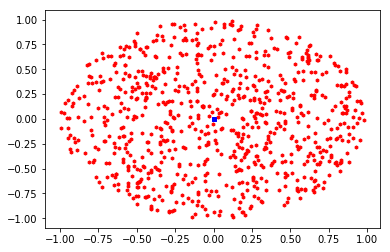

In [5]:
import random
npoints = 1000
#unit circle centered in .0, .0
x = 2.*np.random.rand(npoints)-1
y = 2.*np.random.rand(npoints)-1
x = np.append(x,np.zeros(1))
y = np.append(y,np.zeros(1))
npoints += 1
r = x**2+y**2
print("# of points inside ",r[r<1.].shape)
plt.scatter(x[r<1],y[r<1],marker='h',s=10,color='r')
plt.scatter(x[-1],y[-1],marker='s',s=20,color='b')

In [6]:
dist = np.zeros((npoints,npoints))
for i in range(npoints-1):
    dist[i,i] = 0.
    for j in range(i+1,npoints):
        v1 = np.array((x[i],y[i]))
        v2 = np.array((x[j],y[j]))        
        dist[i,j] = np.linalg.norm(v1-v2)
        dist[j,i] = dist[i,j]

In [7]:
dd = dist[r<=1.,:][:,r<=1.]
NP = dd.shape[0]
AC = apts_coredist(2,dd,NP)
print(dd.shape)
D0 = np.sort(dd[-1,:])
KD = kdens(dd,NP)
value = np.log(NP)**(-1/2)
closest = int(NP/np.log(NP))
knn = D0[closest]
print(AC[-1],KD[-1],value,knn)

(793, 793)
0.346110344167 0.00221999071579 0.387032634404 0.365339187767


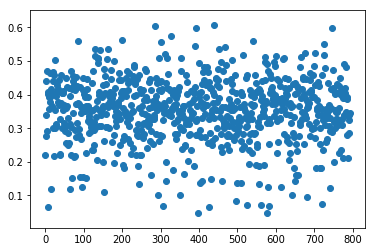

In [8]:
plt.scatter(np.arange(NP),AC)

### Test $a_{pts}coredist$ in 4D hypersphere

In [9]:
npoints = 1000
#unit circle centered in .0, .0, 0., 0.
w = 2.*np.random.rand(npoints)-1
x = 2.*np.random.rand(npoints)-1
y = 2.*np.random.rand(npoints)-1
z = 2.*np.random.rand(npoints)-1
w = np.append(w,np.zeros(1))
x = np.append(x,np.zeros(1))
y = np.append(y,np.zeros(1))
z = np.append(z,np.zeros(1))
npoints += 1
r = w**2 + x**2 + y**2 + z**2
dist = np.zeros((npoints,npoints))
for i in range(npoints-1):
    dist[i,i] = 0.
    for j in range(i+1,npoints):
        v1 = np.array((w[i],x[i],y[i],z[i]))
        v2 = np.array((w[j],x[j],y[j],z[j]))
        dist[i,j] = np.linalg.norm(v1-v2)
        dist[j,i] = dist[i,j]

In [10]:
dd=dist[r<=1.,:][:,r<=1.]
NP = dd.shape[0]
AC = apts_coredist(4,dd,NP)
print(dd.shape)
D0 = np.sort(dd[-1,:])
KD = kdens(dd,NP)
value = np.log(NP)**(-1/4)
closest = int(NP/np.log(NP))
knn = D0[closest]
print(AC[-1],KD[-1],value,knn)

(309, 309)
0.651773896999 0.00546097397169 0.646246273084 0.663648637584


### Test on Iris Data set

In [11]:
#load iris data set
iris = datasets.load_iris()
Xns = iris.data
y = iris.target
print(y)
#scale to mean=0 and unit variance
X = sklearn.preprocessing.scale(Xns)
D = squareform(pdist(X))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [12]:
minPTS = tuple((4,5,6,7,8,9,10))
for m in minPTS:
    
    ######
    try:
        G = kneighbors_graph(X,m,mode='distance',metric="euclidean")
    except DeprecationWarning as e:
        G = G.toarray()
    epsilon = np.mean(G[np.nonzero(G)])
    print("minPTS, epsilon ",m,epsilon)
    #######
    estimator = DBSCAN(eps=epsilon, min_samples=m,metric='euclidean')
    init_clusters = estimator.fit_predict(X)
    centroids = mymetrics2.core2centers(X=X,clusters=init_clusters)
    clusters  = mymetrics2.assign_centroid_label(init_clusters,centroids)
    nout = len(init_clusters[init_clusters==-1])
    #print(clusters,init_clusters,centroids,nout)
    #print("Number of clusters, outliers:",len(centroids),nout)
    #print("CENTROIDS",centroids)

    #######
    try:
        dens_score = DBCV.DBCV(X=X,clusters=clusters,metric="euclidean",NF=4,D=D)
    except:
        continue
    dbcv = dens_score.calc_score(meas='acore')
    
    dens_score = DBCV.DBCV(X=X,clusters=clusters,metric="euclidean",NF=4,D=D)
    dbcv1 = dens_score.calc_score(meas='kernel',cutoff='global')
    
    #######
    ARI = metrics.adjusted_rand_score(clusters,y)
    
    sil = metrics.silhouette_score(X,clusters,metric='euclidean')
    myeval = mymetrics2.cluster_eval(metric='euclidean',clusters=clusters,X=X)
    DBI = myeval(noise="ignore",method="DBI")
    Dunn = myeval(noise="ignore",method="Dunn",inter="allav",intra="allav")
    psf,wss = myeval(noise="ignore",method="psF",centroid=True)
    norm = (len(y)-nout)/len(y)
    print("%8s %8s %8s %8s %8s %8s  %8s" % ("Sil","DBI","Dunn","psF","DBCV","DBCV","ARI"))
    print("%9.5f %9.5f %9.5f %9.5f %9.5f %9.5f  %9.5f"%(sil,DBI,Dunn,psf,dbcv,dbcv1,ARI))
    print("%9.5f %9.5f %9.5f %9.5f %9.5f %9.5f %9.5f"%(sil*norm,DBI/norm,Dunn*norm,psf*norm,dbcv,dbcv1,ARI))

minPTS, epsilon  4 0.435080988026
     Sil      DBI     Dunn      psF     DBCV     DBCV       ARI
  0.21187   0.51071   3.85499 430.67559   0.40955   0.50900    0.40841
  0.13277   0.81496   2.41580 269.89004   0.40955   0.50900   0.40841
minPTS, epsilon  5 0.462606110085
     Sil      DBI     Dunn      psF     DBCV     DBCV       ARI
  0.17152   0.67492   2.04681 377.03425  -0.64667  -0.48433    0.48169
  0.11091   1.04369   1.32360 243.81548  -0.64667  -0.48433   0.48169
minPTS, epsilon  6 0.487557844185
     Sil      DBI     Dunn      psF     DBCV     DBCV       ARI
  0.17664   0.70164   1.22787 292.90617  -0.66611  -0.65248    0.42363
  0.12365   1.00235   0.85951 205.03432  -0.66611  -0.65248   0.42363
minPTS, epsilon  7 0.510497630578
     Sil      DBI     Dunn      psF     DBCV     DBCV       ARI
  0.15014   0.92712   1.24131 234.03523  -0.67239  -0.71333    0.48817
  0.10710   1.29970   0.88547 166.94513  -0.67239  -0.71333   0.48817
minPTS, epsilon  8 0.531739621399
     Sil  